# Exploring heart disease data obtained by the Cleveland Clinic

## Introduction
Our topic revolves around heart disease, specifically attempting to build a model that will predict, given certain factors that will be explained shortly, if a person does have heart disease. We chose to examine biological information of heart-disease patients at the Cleveland Clinic Foundation. This dataset contains 303 observations with 14 variables each; 164 of the patients have no heart disease whereas 139 have at least one heart disease. By looking at the CDC’s information on heart disease<sup>1</sup>  and cross-referencing with this dataset, we picked out the 8 variables that seemed most relevant and crucial to determining our goal. These variables are as follows: age, sex, chest pain type, resting blood pressure, cholesterol level, fasting blood sugar, maximum heart achieved and presence of exercise-induced angina. As such, the overarching question that we seek to answer is: Given the stated variables, does that person have heart disease?

<sup>1</sup> https://www.cdc.gov/heartdisease/risk_factors.htm

## Preliminary exploratory data analysis

First, we will load the tidyverse package to be able to perform data analysis and visualization. This proposal document requires that the tidyverse and tidymodels R packages be downloaded.

In [13]:
library(tidyverse)
library(tidymodels)
set.seed(54321)

Next we read in the data from the file. Although the dataset was provided as a .data file from the original source, the file contains comma-separated values, so we use read_csv. Since the data has no column names, we will rename them all using information available at [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [14]:
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
heart_temp <- tempfile()
download.file(url, heart_temp)
data <- read_csv(unzip(heart_temp, "processed.cleveland.data"), col_names = FALSE, show_col_types = FALSE) |>
    rename(age = X1, sex = X2, chest_pain = X3, resting_blood_pressure = X4,
           cholesterol = X5, fasting_blood_sugar = X6, #1 if above 120mg/L, 0 if below
           resting_ecg = X7, max_heart_rate = X8, exercise_angina = X9,
           st_depression = X10, slope = X11, major_vessels = X12, thal = X13,
           diagnosis = X14)
unlink(heart_temp)

Now since we don't want to use every variable in the data set, we will select only those that we are interested in: age, sex (only for prelim analysis), maximum heart rate achieved, ST depression, thal, and diagnosis. Also, the authors of the data have indicated that all values 1-4 of the diagnosis variable mean a positive diagnosis, so we will combine all those values into 1 to simplify the data.

In [23]:
data_selected <- data |>
    select(age, sex, max_heart_rate, st_depression, thal, diagnosis) |>
    mutate(diagnosis = as_factor(diagnosis)) |>
    mutate(diagnosis = fct_recode(diagnosis, "1" = "2", "1" = "3", "1" = "4"))

glimpse(data_selected)

Rows: 303
Columns: 6
$ age            <dbl> 63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44,…
$ sex            <dbl> 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0…
$ max_heart_rate <dbl> 150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 148, …
$ st_depression  <dbl> 2.3, 1.5, 2.6, 3.5, 1.4, 0.8, 3.6, 0.6, 1.4, 3.1, 0.4, …
$ thal           <chr> "6.0", "3.0", "7.0", "3.0", "3.0", "3.0", "3.0", "3.0",…
$ diagnosis      <fct> 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0…


Now we will split the data into a training and testing set for the preliminary data analysis and building our classification model.

In [24]:
data_split <- initial_split(data_selected)
data_training <- training(data_split)
data_testing <- testing(data_split)

Since the data is already tidy, our next step is to explore the data. In order to better visualize the data, the variables that are actually categories but are stored as integers (i.e. sex, chest pain, and fasting blood sugar) will be converted to factor variables. The explanations of the numerical categories were provided by the authors of the data set, available at [https://archive.ics.uci.edu/dataset/45/heart+disease].

In [26]:
data_converted <- data_training |>
    mutate(sex = as_factor(sex)) |>
    mutate(sex = fct_recode(sex, "Male" = "1", "Female" = "0"))

data_converted <- data_converted |>
    mutate(diagnosis = fct_recode(diagnosis,
                            "Angiographic disease" = "1",
                            "Healthy" = "0"))

data_converted <- data_converted |>
    mutate(thal = as_factor(thal)) |>
    mutate(thal = fct_recode(thal,
                             "Normal" = "3.0",
                             "Fixed defect" = "6.0",
                             "Reversable defect" = "7.0"))

glimpse(data_converted)

Rows: 227
Columns: 6
$ age            <dbl> 58, 71, 62, 68, 63, 60, 64, 45, 60, 59, 52, 59, 37, 60,…
$ sex            <fct> Male, Female, Female, Male, Male, Male, Female, Male, M…
$ max_heart_rate <dbl> 154, 162, 160, 151, 132, 160, 122, 170, 170, 140, 178, …
$ st_depression  <dbl> 0.6, 0.4, 3.6, 1.0, 1.8, 1.4, 2.0, 0.0, 1.2, 3.4, 1.2, …
$ thal           <fct> Reversable defect, Normal, Normal, Reversable defect, R…
$ diagnosis      <fct> Healthy, Healthy, Angiographic disease, Healthy, Angiog…


Here we see that the data values were successfully renamed. Now we will summarize some information about the data, including counting the number of observations for each diagnosis, the number of males vs. females, the average of our numerical predictor variables (age, maximum heart rate, and st_depression), and the number of rows with missing values in the data set (note that the authors of the data set specified that -9.0 is used in place of missing values).

In [29]:
number_of_observations <- data_converted |>
    group_by(diagnosis) |>
    summarize(count = n())

genders <- data_converted |>
    group_by(sex) |>
    summarize(count = n())

mean_values <- data_converted |>
    select(age, max_heart_rate, st_depression) |>
    summarize(mean_age = mean(age), mean_max_maximum_heart_rate = mean(max_heart_rate), mean_st_depression = mean(st_depression))

missing_data <- data_converted |>
    filter(age == -9.0 | sex == "-9.0" | max_heart_rate == -9.0 |
           st_depression == -9.0 | thal == "-9.0" | diagnosis == "-9.0" | sex == "?" | thal == "?" | diagnosis == "?")

number_of_missing_data <- missing_data |>
    summarize(number_of_missing_values = n())

number_of_observations
genders
mean_values
missing_data
number_of_missing_data

diagnosis,count
<fct>,<int>
Healthy,125
Angiographic disease,102


sex,count
<fct>,<int>
Female,73
Male,154


mean_age,mean_max_maximum_heart_rate,mean_st_depression
<dbl>,<dbl>,<dbl>
54.27753,150.1498,1.071366


age,sex,max_heart_rate,st_depression,thal,diagnosis
<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>
52,Male,156,1,?,Angiographic disease


number_of_missing_values
<int>
1


So we see that, luckily, only 1 row has missing data. To make it more useful, we will rename the "?" to N/A in the code below. Additionally, the classes appear to be roughly balanced, with around the same number of positive diagnoses as negative (healthy).

In [33]:
data_converted <- mutate(data_converted, thal = ifelse(thal == "?", NA, thal))

data_missing <- filter(data_converted, if_any(everything(), is.na))
data_missing

age,sex,max_heart_rate,st_depression,thal,diagnosis
<dbl>,<fct>,<dbl>,<dbl>,<int>,<fct>
52,Male,156,1,NA,Angiographic disease


Now we further explore the data by visualizing it in order to discern any patterns in the data.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


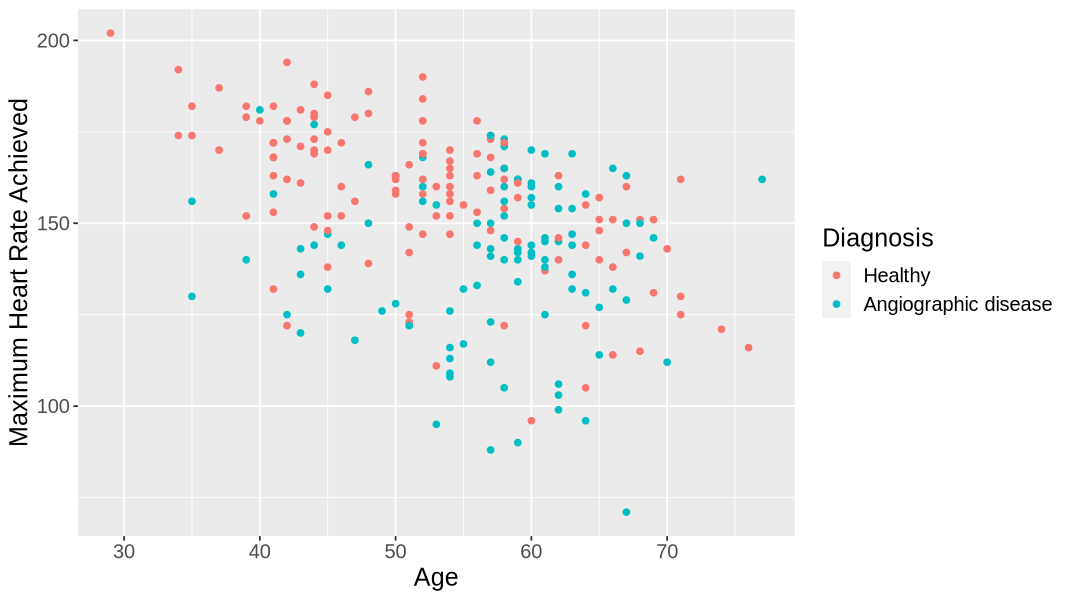

Warning message:
“Removed 1 rows containing non-finite values (`stat_count()`).”


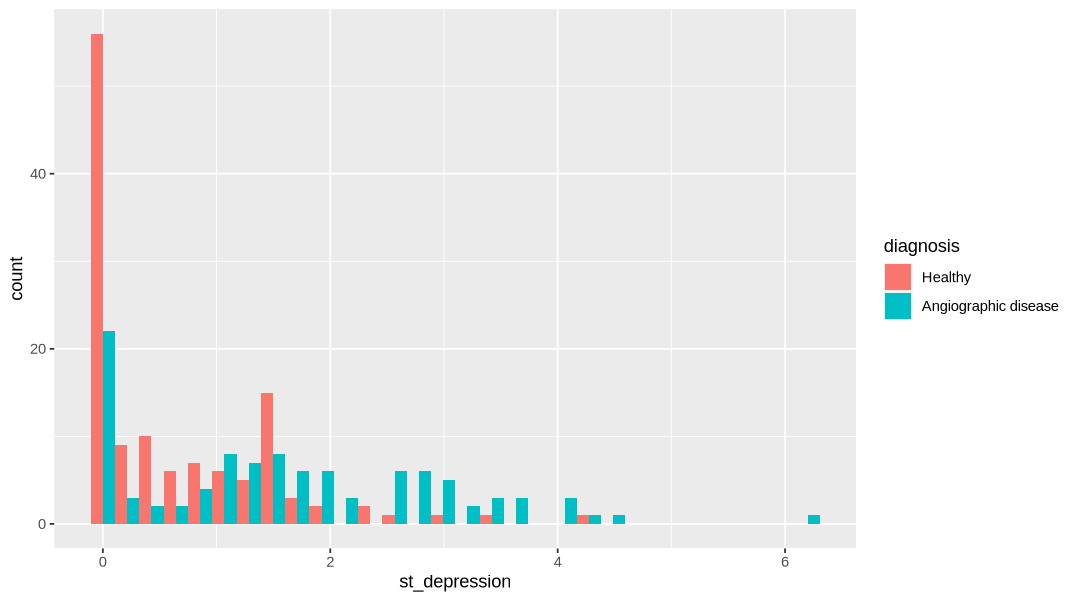

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


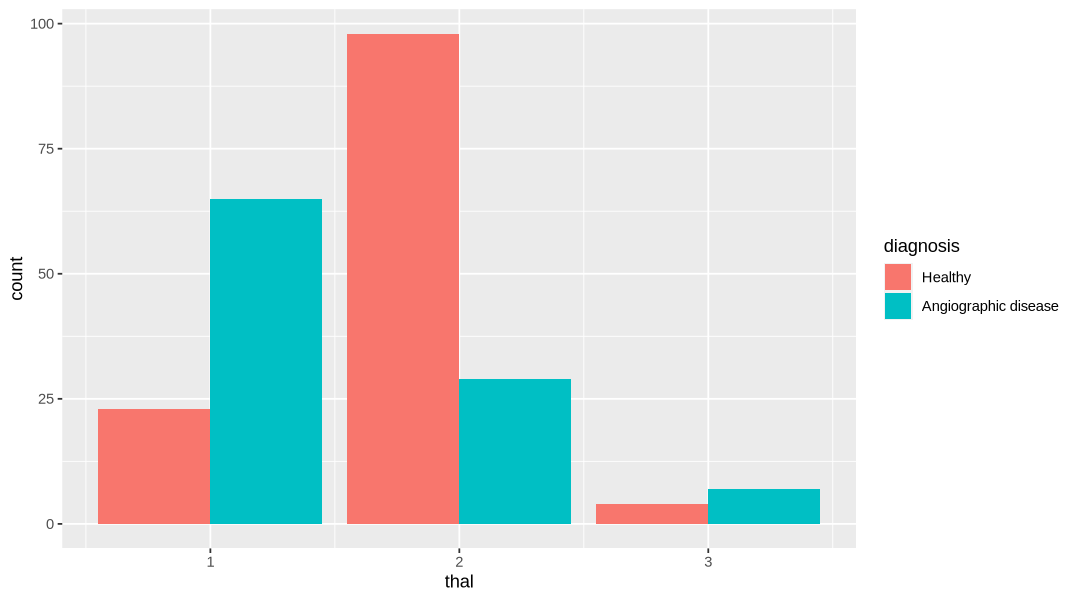

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


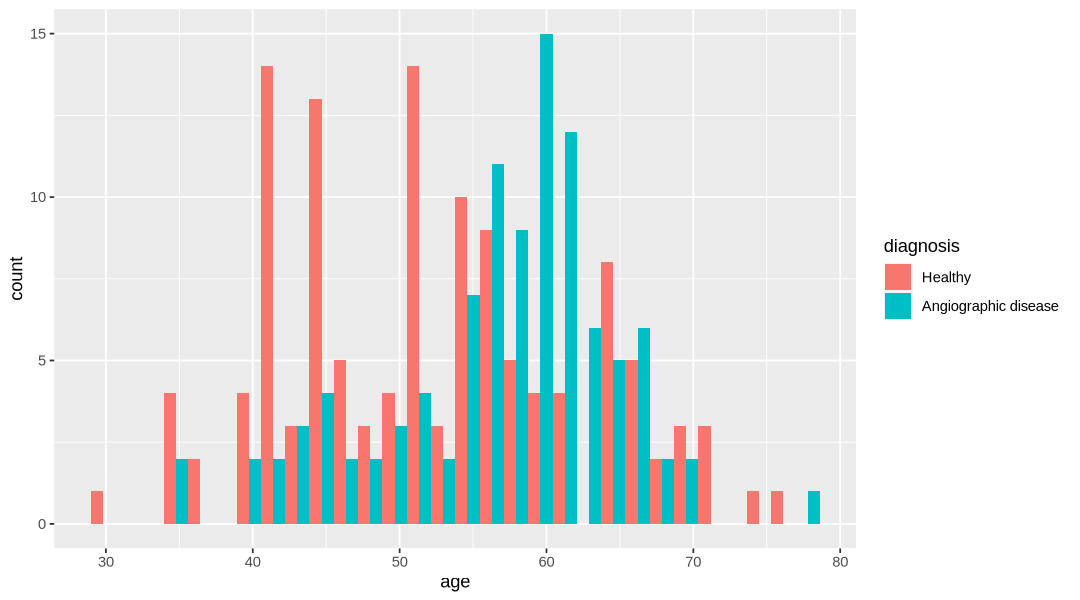

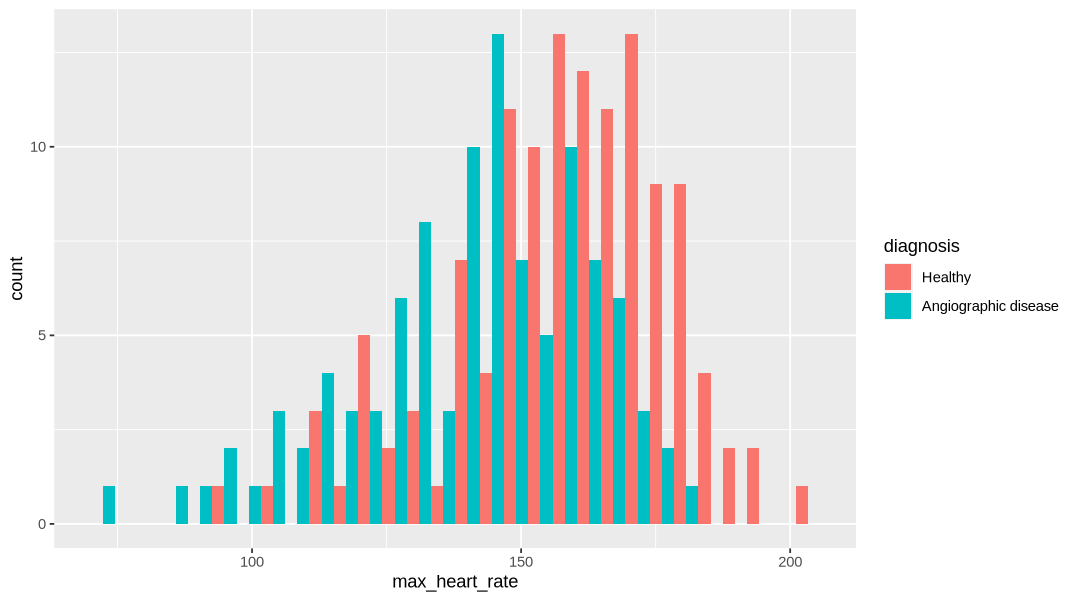

In [34]:
options(repr.plot.width = 9, repr.plot.height = 5)

graph_1 <- data_converted |>
    ggplot(aes(x = age, y = max_heart_rate, colour = diagnosis)) +
    geom_point() +
    labs(x = "Age", y = "Maximum Heart Rate Achieved", colour = "Diagnosis") +
    theme(text = element_text(size = 15))
graph_1

graph_5 <- data_converted |>
    ggplot(aes(x = st_depression, fill = diagnosis)) +
    geom_histogram(position = "dodge")
graph_5

graph_6 <- data_converted |>
    ggplot(aes(x = thal, fill = diagnosis)) +
    geom_bar(position = "dodge")
graph_6

graph_age <- data_converted |>
    ggplot(aes(x = age, fill = diagnosis)) +
    geom_histogram(position = "dodge")
graph_age

graph_heart_rate <- data_converted |>
    ggplot(aes(x = max_heart_rate, fill = diagnosis)) +
    geom_histogram(position = "dodge")
graph_heart_rate

From the graphs, the diagnosis of an individual appears to have a correlation with maximum heart rate, age, thal, and st_depression.

# Methods:
Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
Describe at least one way that you will visualize the results

# Expected outcomes and significance:
What do you expect to find?
What impact could such findings have?
What future questions could this lead to?